### Multiscale Finite Element (MsFEM) in 2D

by Salih Kilicli - 3/31/2020 (Quarantine Days in San Antonio, TX, USA)

### Problem setting

##### Strong Formulation:

$$- div(\kappa(x) \nabla u(x)) = f(x) \quad \text{in}  \quad \Omega \subset R^d$$

$$ u(x) = 0 \quad \text{on} \quad x \in \partial \Omega$$

##### Weak Formulation (Galerkin):

Find $u_h \in V_h$ such that:

$$a(u_h, \ v) = \int\limits_{\Omega} \kappa(x) \nabla u_h(x) \nabla v(x) dx = \int\limits_{\Omega} f(x) v(x) dx = L(v)$$

for $\forall v \in V$.

In [341]:
# Importing necessary libraries

from scipy.interpolate import griddata
from scipy.sparse import csr_matrix, diags, tril, identity
from scipy.sparse.linalg import lsqr, lsmr, spsolve
import scipy as sp
import numpy as np
np.set_printoptions(linewidth=150, precision=5, floatmode='fixed')
#from numpy.linalg import lstsq (slow for sparse matrix problems)
import pandas as pd
pd.set_option('precision', 12)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [342]:
%matplotlib inline

In [343]:
# Options for Visualization

enumerate_index         = False;
visualize_medium        = True;
visualize_fine_solution = True;
visualize_ms_solution   = True;

# Option for offline - online stage (True online, False offline)

compute_ms_basis        = True;

#### Coarse-Fine Mesh Settings

$N_x, N_y$ $(n_x, n_y)$ are the number of elements in each coarse (fine) dimension $x$ and $y$.

$H_x = \frac{1}{N_x}, H_y = \frac{1}{N_y}$ $(h_x = \frac{1}{N_x * n_x}, h_y = \frac{1}{N_y * n_y})$ are the step size in each coarse (fine) dimension $x$ and $y$.



In [344]:
# Mesh Settings # Total Nodes: (Nx*nx+1)x(Ny*ny+1) = lx*ly

# Coarse partition
Nx, Ny = 10, 10
Hx, Hy = 1/Nx, 1/Ny

# Fine partition
nx, ny = 6, 6
hx, hy = Hx/nx, Hy/ny

In [345]:
# Problem setup

# Permeability field
df = pd.read_csv("permeability.txt", header=None)
kappa = df.to_numpy().reshape((600, 600), order='F')
#kappa = np.ones((600, 600))

# Source term
f = lambda x, y: 1 + 0*x*y

# Boundary Conditions (BC) for the source term
f0 = lambda x,y: 0*x*y

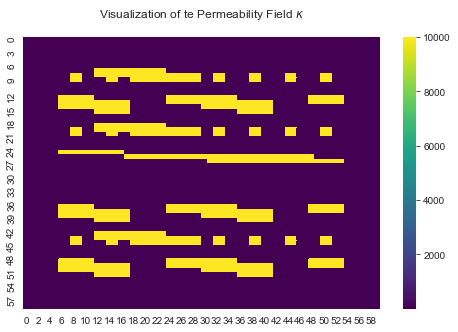

In [346]:
# Visualization of the Mesh grid
lx = Nx*nx+1
ly = Ny*ny+1

if enumerate_index:
    (X, Y) = np.meshgrid(np.linspace(0, 1, lx), np.linspace(0, 1, ly))
    X = X.flatten(order ='F')
    Y = Y.flatten(order ='F')
    Z = np.arange(1, ly*lx+1).reshape((-1, 1), order='F')
    for i in range(X.shape[0]):
        plt.text(X[i], Y[i], str(Z[i][0]))
        plt.axis('off')      
    plt.title('Visualization of the Mesh Grid Nodes\n\n')
    plt.tight_layout()
    plt.show()
    
# Visualization of the Permeability field
(m, n) = kappa.shape
(hx_a, hy_a) = 1/m, 1/n
(X_a, Y_a) = np.meshgrid(np.arange(hx_a/2, 1, hx_a), np.arange(hy_a/2, 1, hy_a))
(X, Y) = np.meshgrid(np.arange(hx/2, 1, hx), np.arange(hy/2, 1, hy))
points = np.hstack((X_a.flatten(order ='F').reshape(-1, 1), Y_a.flatten(order ='F').reshape(-1, 1)))
pfield = griddata(points, kappa.flatten(order ='F'), (X, Y), method='nearest')

plt.figure(figsize=(8,5))
if visualize_medium:
    sns.heatmap(pfield, cmap='viridis')
    #plt.imshow(pfield, cmap='viridis', interpolation='nearest')
    plt.title('Visualization of te Permeability Field $\kappa$ \n')
    plt.show()

In [347]:
# Fine-scale problem Matrix System

def finematrix_2d(pfield, Nx, Ny, nx, ny):
    xdim = Nx*nx
    ydim = Ny*ny
    (hx, hy) = (1/xdim, 1/ydim)
    (ratiox, ratioy) = (xdim/ydim, ydim/xdim)
    
    idx = np.arange(1, lx*ly+1).reshape((ydim+1, xdim+1), order='F')
    bdry1 = idx[0, :]
    bdry2 = idx[-1, :]
    bdry3 = idx[1:-1, 0]
    bdry4 = idx[1:-1,-1]
    boundary = np.hstack((bdry1, bdry2, bdry3, bdry4))
    
    idx1 = idx[0:-1, 0:-1].reshape((-1, 1), order='F') #same with .flatten(order='F').reshape(-1,1)
    idx2 = (idx1 + (xdim+1)).reshape((-1, 1), order='F')
    idx3 = (idx1 + 1).reshape((-1, 1), order='F')
    idx4 = (idx1 + 1 + (ydim+1)).reshape((-1, 1), order='F')
    
    
    lst1 = np.array([2, -2, 1, -1, -2, 2, -1, 1, 1, -1, 2, -2, -1, 1, -2, 2]).reshape(-1, 1)
    lst2 = np.array([2, 1, -2, -1, 1, 2, -1, -2, -2, -1, 2, 1, -1, -2, 1, 2]).reshape(-1, 1)
    data1= np.kron(lst1*ratiox + lst2*ratioy, pfield.reshape((-1, 1), order='F'))/6
    lst3 = np.array([1/9,1/18,1/18,1/36, 1/18,1/19,1/36,1/18, 1/18,1/36,1/9,1/18, 1/36,1/18,1/18,1/9]).reshape(-1,1)
    data2= np.kron(lst3, np.ones(pfield.reshape(-1,1).shape))*(hx*hy)
    row_ind = np.tile(np.vstack((idx1, idx2, idx3, idx4)), (4,1))
    col_ind = np.vstack((np.tile(idx1, (4,1)), np.tile(idx2, (4,1)), np.tile(idx3, (4,1)), np.tile(idx4, (4,1))))
    Global_DA = csr_matrix((data1.reshape(-1), (row_ind.reshape(-1)-1, col_ind.reshape(-1)-1)))
    Global_M  = csr_matrix((data2.reshape(-1), (row_ind.reshape(-1)-1, col_ind.reshape(-1)-1)))
    
    return Global_DA, Global_M, boundary

In [348]:
# Forming Source Term

def form_source(F, Nx, Ny, nx, ny):
    xdim = Nx*nx
    ydim = Ny*ny
    (hx, hy) = (1/xdim, 1/ydim)
    idx = np.arange(1, (xdim+1)*(ydim+1)+1).reshape((ydim+1, xdim+1), order='F')
    
    idx1 = idx[0:-1, 0:-1].reshape((-1, 1), order='F')  #same with flatten(order='F').reshape(-1,1)
    idx2 = (idx1 + (xdim+1)).reshape((-1, 1), order='F')
    idx3 = (idx1 + 1).reshape((-1, 1), order='F')
    idx4 = (idx1 + 1 + (ydim+1)).reshape((-1, 1), order='F')
    
    data= np.kron(np.ones((4,1)), f(X,Y).reshape((-1,1), order='F'))*hx*hy/4
    row_ind = np.vstack((idx1-1, idx2-1, idx3-1, idx4-1))
    col_ind = np.zeros((4*xdim*ydim, 1),  dtype=int)
    F = csr_matrix((data.reshape(-1), (row_ind.reshape(-1), col_ind.reshape(-1))))
    return F.toarray(order='F')

### Fine-scale Matrix system

#### Homogeneous Neumann problem (includes the boundary nodes)

- Global_DA := fine-scale stiffness matrix
- Global_M   := fine-scale mass matrix
- Global_b   := fine-scale load vector
- bdry_idx   := boundary index of dofs in global numbering

#### Dirichlet problem (excludes the boundary nodes)

- fine_DA    := fine-scale stiffness matrix
- fine_M     := fine-scale mass matrix
- fine_RHS   := fine-scale load vector
- inter_idx  := index of interior dofs in global numbering


In [349]:
# Fine Scale Matrix System

# Homogeneous Neumann Problem
(Global_DA, Global_M, bdry_idx) = finematrix_2d(pfield, Nx, Ny, nx, ny)
(X, Y) = np.meshgrid(np.arange(hx/2, 1, hx), np.arange(hy/2, 1, hy))
F = f(X,Y)
Global_F = form_source(F, Nx, Ny, nx, ny)

# Dirichlet Problem
inter_idx = np.arange(1, lx*ly+1)
inter_idx = np.delete(inter_idx, bdry_idx-1) #deletes boundary indices
fine_DA   = Global_DA[np.ix_(inter_idx-1, inter_idx-1)]
fine_M    = Global_M[np.ix_(inter_idx-1, inter_idx-1)]
fine_F    = Global_F[inter_idx-1]

(X, Y) = np.meshgrid(np.linspace(0, 1, Nx*nx+1), np.linspace(0, 1, Ny*ny+1))
bfc = f0(X, Y)
bfc[1:-1, 1:-1] = 0
fine_bF = -Global_DA[inter_idx-1, :]@bfc.reshape((-1, 1), order='F') #np.matmul(A, B) = A@B
fine_RHS = fine_F + fine_bF

In [350]:
#list(map(lambda x: list(x)+[fine_M[x]], zip(*fine_M.nonzero())))

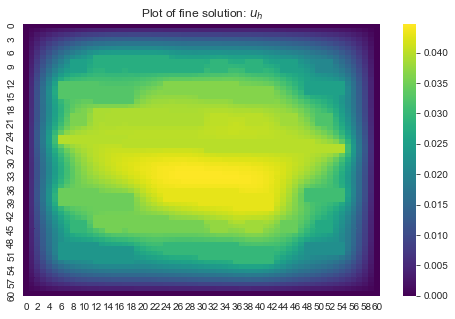

In [371]:
# Fine-scale solution
fine_U = spsolve(fine_DA, fine_RHS, use_umfpack=True) #np.linalg.lstsq

plt.figure(figsize=(8, 5))
if visualize_fine_solution:
    plot_fine = bfc
    plot_fine[1:-1, 1:-1] = fine_U.reshape((Ny*ny-1, Nx*nx-1), order='F')
    sns.heatmap(plot_fine, cmap='viridis')
    plt.title('Plot of fine solution: $u_h$')

In [352]:
u_h = pd.DataFrame(plot_fine, columns = np.arange(plot_fine.shape[1]), index=None)
u_h.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,...,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.0
1,0.0,0.000746408444,0.001333825952,0.001835510484,0.002276065682,0.002667729882,0.003017366583,0.003329232153,0.003606271764,0.003850639296,...,0.003258867126,0.003071442854,0.002855825201,0.002608125467,0.002324448055,0.002000023373,0.001627663818,0.001194874480,0.000676816355,0.0
2,0.0,0.001336248339,0.002467859926,0.003451247088,0.004321751891,0.005098952773,0.005794368791,0.006415315735,0.006967201021,0.007454452571,...,0.006264037024,0.005893458075,0.005466022076,0.004974219800,0.004411155268,0.003768727201,0.003034859305,0.002189492848,0.001196830181,0.0
3,0.0,0.001845212749,0.003463346308,0.004897746713,0.006180536416,0.007332892760,0.008367576847,0.009292550257,0.010114625131,0.010841187925,...,0.009039836452,0.008495129247,0.007863171287,0.007133471340,0.006298206374,0.005348687201,0.004271440882,0.003044631305,0.001635493127,0.0
4,0.0,0.002300401764,0.004360512319,0.006214208234,0.007889178189,0.009404980347,0.010772463491,0.011995757291,0.013079760418,0.014037442497,...,0.011611664328,0.010908073790,0.010081437615,0.009120225023,0.008019999944,0.006775831885,0.005375943412,0.003800020567,0.002019636782,0.0


In [353]:
def MsFEM_2d_basis(Global_DA, Nx, Ny, nx, ny):
    loc_basis = np.zeros((lx*ly, (Nx+1)*(Ny+1))) # lz = Nz*nz+1 for z in {x, y}
    F = np.zeros(((nx+1)*(ny+1), 4))
    loc_boundary1 = np.arange(0, (ny+1)*(nx+1), ny+1)                 
    loc_boundary2 = np.arange(ny, (ny+1)*(nx+1), ny+1)          
    loc_boundary3 = np.arange(1, ny)
    loc_boundary4 = np.arange(nx*(ny+1)+1, (ny+1)*(nx+1)-1)
    loc_boundary = np.hstack((loc_boundary1, loc_boundary2, loc_boundary3, loc_boundary4))
    
    (loc_X, loc_Y) = np.meshgrid(np.linspace(0, 1, nx+1), np.linspace(0, 1, ny+1))
    # X.T.flat is same with X.flatten.reshape((-1, 1), order='F') or X.respahe((-1,1), order='F')
    # X.flat gives the flattened matrix in 'C' format, while X.T.flat is in 'F' format
    
    F[loc_boundary, 0] = (1-loc_X.T.flat[loc_boundary])*(1-loc_Y.T.flat[loc_boundary])
    F[loc_boundary, 1] = (1-loc_X.T.flat[loc_boundary])*(  loc_Y.T.flat[loc_boundary])
    F[loc_boundary, 2] = (  loc_X.T.flat[loc_boundary])*(1-loc_Y.T.flat[loc_boundary])
    F[loc_boundary, 3] = (  loc_X.T.flat[loc_boundary])*(  loc_Y.T.flat[loc_boundary])
    
    idx = np.arange(lx*ly).reshape(ly, lx, order='F')
    for i in np.arange(Nx):
        for j in np.arange(Ny):
            loc_idx = idx[np.ix_(j*ny + np.arange(ny+1), i*nx + np.arange(nx+1))] #np.ix_ for submatrices
            #loc_idx = loc_idx.reshape(-1, order='F')       #loc_idx.T.flat is the same but is an iterator
            loc_A = Global_DA.todense()[np.ix_(loc_idx.T.flat, loc_idx.T.flat)]
            loc_A[loc_boundary, :] = 0
            ##loc_A[loc_boundary, loc_boundary] = identity(2(ny+nx)) #sparse identity matrix
            loc_A.flat[loc_boundary+(loc_boundary)*loc_A.shape[0]] = 1
            loc_basis[np.ix_(loc_idx.T.flat, [i*(Ny+1)+j, i*(Ny+1)+j+1, (i+1)*(Ny+1)+j, (i+1)*(Ny+1)+j+1])] = \
            spsolve(csr_matrix(loc_A), F, use_umfpack=True)           
    return loc_basis

In [354]:
#loc_A = MsFEM_2d_basis(Global_DA, Nx, Ny, nx, ny)

#displaying locations and values of an sparse array
#list(map(lambda x: list(x)+[loc_A[x]], zip(*loc_A.nonzero())))

In [355]:
# Offline-Online Multiscale Basis Functions

if compute_ms_basis:
    MS_basis = MsFEM_2d_basis(Global_DA, Nx, Ny, nx, ny)
    np.savetxt('MS_basis.csv', MS_basis)
else:
    np.loadtxt('MS_basis.csv')

### Multiscale Matrix System

In [356]:
# Multiscale Matrix System

inter_idx_coarse = np.arange((Nx+1)*(Ny+1))
bdry1 = np.arange(0, (Nx+1)*(Ny+1), Ny+1)
bdry2 = np.arange(Ny,(Nx+1)*(Ny+1), Ny+1)
bdry3 = np.arange(1, Ny)
bdry4 = (Ny+1)*Nx + np.arange(1, Ny)
bdry_coarse = np.hstack((bdry1, bdry2, bdry3, bdry4)).flatten()
inter_idx_coarse = np.delete(inter_idx_coarse, bdry_coarse)

ms_basis = MS_basis[inter_idx-1, :]
ms_DA    = ms_basis.T@fine_DA@ms_basis
ms_M     = ms_basis.T@fine_M@ms_basis
ms_F     = ms_basis.T@fine_F

(X, Y) = np.meshgrid(np.linspace(0, 1, Nx+1), np.linspace(0, 1, Ny+1))
ms_bfc = f0(X, Y)
ms_bfc[1:-1, 1:-1] = 0
ms_bF = -ms_DA.T@ms_bfc.reshape((-1, 1), order='F')
ms_RHS = ms_F + ms_bF

ms_DA = ms_DA[np.ix_(inter_idx_coarse, inter_idx_coarse)]
ms_M  = ms_M[np.ix_(inter_idx_coarse, inter_idx_coarse)]
ms_basis = ms_basis[:, inter_idx_coarse]
ms_RHS = ms_RHS[inter_idx_coarse]

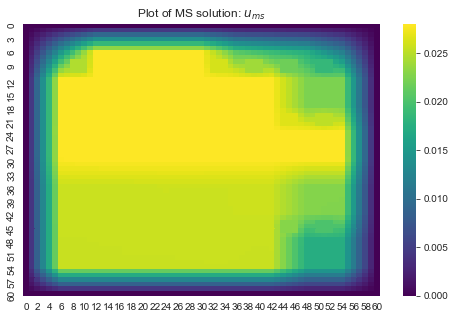

In [362]:
# MsFEM Solution and Visualization

ms_U = spsolve(csr_matrix(ms_DA), ms_RHS, use_umfpack=True)
ms_U_fine = ms_basis @ ms_U

plt.figure(figsize=(8, 5))
if visualize_ms_solution:
    plot_ms = bfc
    plot_ms[1:-1, 1:-1] = ms_U_fine.reshape((Ny*ny-1, Nx*nx-1), order='F')
    sns.heatmap(plot_ms, cmap='viridis')
    plt.title('Plot of MS solution: $u_{ms}$') 

In [363]:
u_ms = pd.DataFrame(plot_ms, columns = np.arange(plot_ms.shape[1]), index=None)
u_ms.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,...,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.000000000000,0.0
1,0.0,0.000416332028,0.000832664056,0.001248996084,0.001665328111,0.002081660139,0.002497992167,0.002856223392,0.003214454617,0.003572685842,...,0.002480185946,0.002329286490,0.002178387034,0.002027487578,0.001689572982,0.001351658385,0.001013743789,0.000675829193,0.000337914596,0.0
2,0.0,0.000832664056,0.001665328111,0.002497992167,0.003330656223,0.004163320278,0.004995984334,0.005712446784,0.006428909234,0.007145371683,...,0.004960371893,0.004658572980,0.004356774068,0.004054975156,0.003379145963,0.002703316771,0.002027487578,0.001351658385,0.000675829193,0.0
3,0.0,0.001248996084,0.002497992167,0.003746988251,0.004995984334,0.006244980418,0.007493976501,0.008568670176,0.009643363850,0.010718057525,...,0.007440557839,0.006987859471,0.006535161102,0.006082462734,0.005068718945,0.004054975156,0.003041231367,0.002027487578,0.001013743789,0.0
4,0.0,0.001665328111,0.003330656223,0.004995984334,0.006661312445,0.008326640557,0.009991968668,0.011424893568,0.012857818467,0.014290743367,...,0.009920743785,0.009317145961,0.008713548136,0.008109950312,0.006758291927,0.005406633541,0.004054975156,0.002703316771,0.001351658385,0.0


#### Comparison of Fine and Multiscale Solution: $ \ u_h \approx u_{ms}$

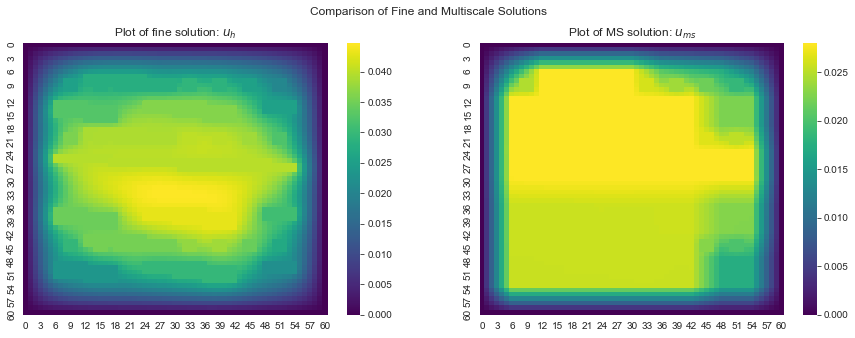

In [364]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.suptitle('Comparison of Fine and Multiscale Solutions')

if visualize_fine_solution:
    plot_fine = bfc
    plot_fine[1:-1, 1:-1] = fine_U
    sns.heatmap(plot_fine, cmap='viridis', ax=ax1)
    ax1.set_title('Plot of fine solution: $u_h$')
    
if visualize_ms_solution:
    plot_ms = bfc
    plot_ms[1:-1, 1:-1] = ms_U_fine.reshape((ly-2, lx-2), order='F') #lz = (Nz*nz+1)
    sns.heatmap(plot_ms, cmap='viridis', ax=ax2)
    ax2.set_title('Plot of MS solution: $u_{ms}$')

#### Error Analysis - Calculating Relative Errors

In [389]:
U_ms = ms_U_fine.reshape((-1, 1), order='F')
U_h  = fine_U.reshape((-1, 1), order='F')

DG_error = ((U_ms - U_h).T @ fine_DA @ (U_ms - U_h))/(U_h.T @ fine_DA @ U_h)
L2_error = ((U_ms - U_h).T @ fine_M  @ (U_ms - U_h))/(U_h.T @ fine_DA @ U_h)

print(f'The relative Energy Error for MsFEM: \t {np.sqrt(*DG_error[0])*100:5.3f}%')
print(f'The relative   L2   Error for MsFEM: \t {np.sqrt(*L2_error[0])*100:5.3f}%')

The relative Energy Error for MsFEM: 	 46.688%
The relative   L2   Error for MsFEM: 	 4.902%
